In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import umpm
from mvpose.algorithm.settings import get_settings, get_tracking_settings

from mvpose.geometry.camera import ProjectiveCamera


Calib = []


root = '/home/julian/Videos/Ohhun2/'

FRAME = 200

def get_frame(FRAME):
    
    rvec1 = np.array([0.16970309, -0.63595406, -0.02899049])
    rvec2 = np.array([-0.04594394,  2.47154486 , 1.05356694])
    rvec3 = np.array([0.11478388, -2.60716985, -0.43695601])
    rvec4 = np.array([  0.50248564, -0.07703968, -0.00756907])
    rvec5 = np.array([0.11986254, 2.8707059,  0.58209686])
    RVECS = [rvec1, rvec2, rvec3, rvec4, rvec5]

    tvec1 = np.array([0.52766722, 0.44539547, 0.76997935])
    tvec2 = np.array([-0.72519327, -1.56923138,  3.54766366])
    tvec3 = np.array([1.94478036, -0.81084625 , 5.06761023])
    tvec4 = np.array([-0.875338  ,  0.45527339 ,-0.08985231])
    tvec5 = np.array([ 0.429569 ,  -0.96227696,  3.29255734])
    TVECS = [tvec1, tvec2, tvec3, tvec4, tvec5]
    
    Ims = []
    for cid in range(1, 6):
        #fname = 'test1_cam%1d-011.mp4' % cid
        fname = '180801_%1d-007.mp4' % cid
        fname = join(root, fname)
        assert isfile(fname)

        cap = cv2.VideoCapture(fname)
        for f in range(FRAME):
            ret, frame = cap.read()
        
        im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #im = cv2.resize(im, None, fx=0.5, fy=0.5)
        Ims.append(im)

        fname_c = 'cam%1d.txt' % cid
        fname_c = join(root, fname_c)
        assert isfile(fname_c)
        param_intrinsic = np.loadtxt(fname_c)
        K = param_intrinsic[:9].reshape(3,3)
        dist = param_intrinsic[9:]

        h, w, _ = Ims[0].shape
        rvec = RVECS[cid-1]
        tvec = TVECS[cid-1]
        Calib.append(ProjectiveCamera(K, rvec, tvec, dist, w, h))
    return Ims, Calib

Im, Calib = get_frame(FRAME)
    

# fig = plt.figure(figsize=(16,12))
# for idx, im in enumerate(Im):
#     ax = fig.add_subplot(3,2,idx+1)
#     ax.axis('off')
#     ax.imshow(im)
    
# plt.show()

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for cam in Calib:
#     print(cam.get_C())

In [3]:
# fig = plt.figure(figsize=(16,12))
# for idx, (im, cam) in enumerate(zip(Im, Calib)):
#     ax = fig.add_subplot(3,2,idx+1)
#     ax.axis('off')
#     ax.imshow(im, alpha=0.5)
    
#     pt3d = np.array([[0, 0, 0]], 'float32')
#     x, y = np.squeeze(cam.projectPoints(pt3d))
#     ax.scatter(y, x, s=100)

In [4]:
# pt3d = np.array([
#     [0, 0, 0]
# ], 'float32')

# cid = 2

# cam = Calib[cid]

# print(cam.tvec)

# im = Im[cid]

# x, y = np.squeeze(cam.projectPoints(pt3d))

# # ==================
# rvec = np.array([[ 0.11478388],
#        [-2.60716985],
#        [-0.43695601]])

# # ==================

# pp = cv2.projectPoints(pt3d, rvec, cam.tvec, cam.K, cam.distCoef)[0]

# print(x, y)
# print(pp)

# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)

# ax.imshow(im, alpha=0.5)
# ax.scatter(x, y, s=50)

# plt.show()

In [5]:
from mvpose import pose
from mvpose.plot.limbs import draw_mscoco_human
from mvpose.algorithm import settings

frame = FRAME
heatmaps, pafs = paf_loader.load_confidence_map_and_paf('ohhun', 
                                                        Im,
                                                        frame,
                                                        dir='/tmp')

params = settings.get_settings(scale_to_mm=1000,
                              max_epi_distance=30)

_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs, 
                                  settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
print("# detections", len(detections))

step 1: elapsed 4.005420684814453
step 2: elapsed 0.011456489562988281
step 3: elapsed 0.03034663200378418
step 4: elapsed 1.241499662399292
-------------------------------------------
Handle transitivity:
	Intra:		 1
	Intra(choice):	 0
	Inter:		 11
	Inter(choice):	 2
-------------------------------------------
	Time =  14  ms
	result: 0

	Total cost: 282.4194375944763

# valid points:		 24
# invalid points:	 0
step 5: elapsed 0.01595902442932129
(smart candidate selection) [
	Time =  3  ms
	result: 0

	Total cost: 1.6443740439682288
] (smart candidate selection)
step 7: elapsed 0.010378360748291016

total elapsed: 5.316580057144165
# detections 1


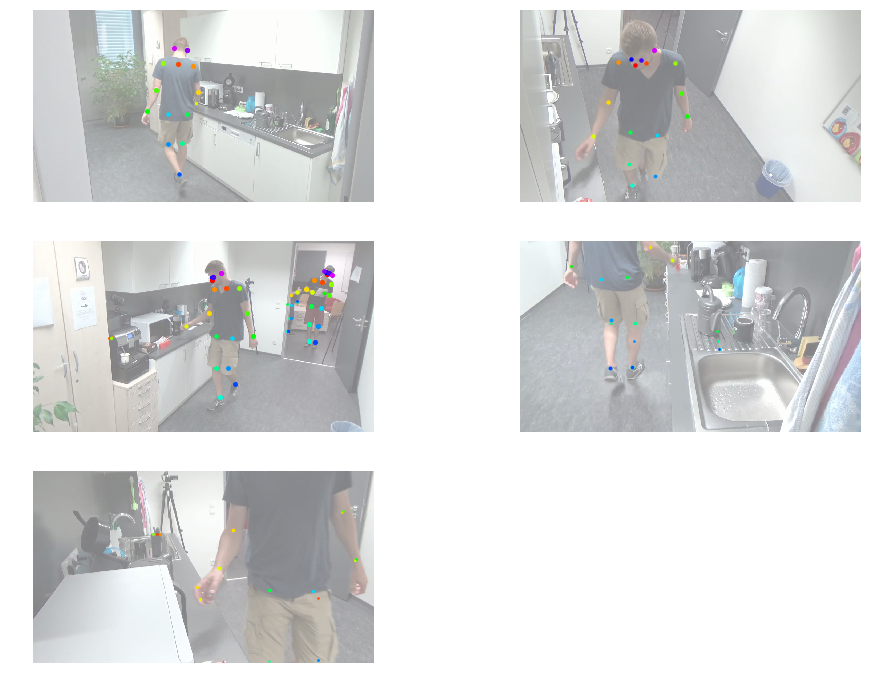

In [6]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(3, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    peaks2d = Debug.candidates2d.peaks2d[cid]
    for jid, peaks2d in enumerate(peaks2d):
        for x, y, s in peaks2d:
            ax.scatter(x, y, color=colors[jid], s=s*20)
    
plt.show()

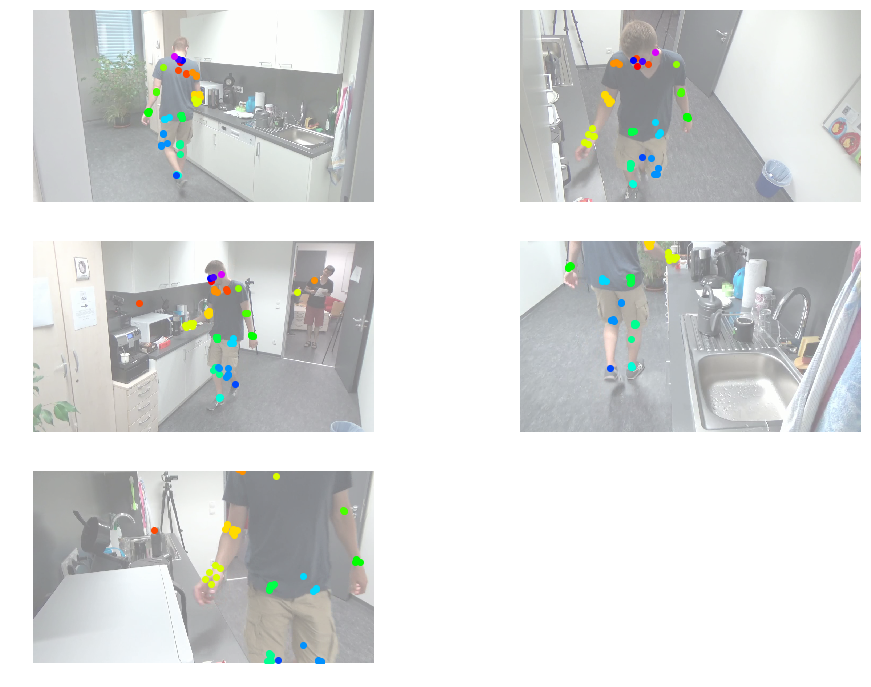

In [7]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(3, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid, peaks in enumerate(Debug.triangulation.peaks3d_weighted):
        if len(peaks) == 0:
            continue
        peaks3d = peaks[:, 0:3].astype('float32')
        peaks2d = cam.projectPoints(peaks3d)
        ax.scatter(peaks2d[:,0], peaks2d[:, 1], color=colors[jid])
    
plt.show()

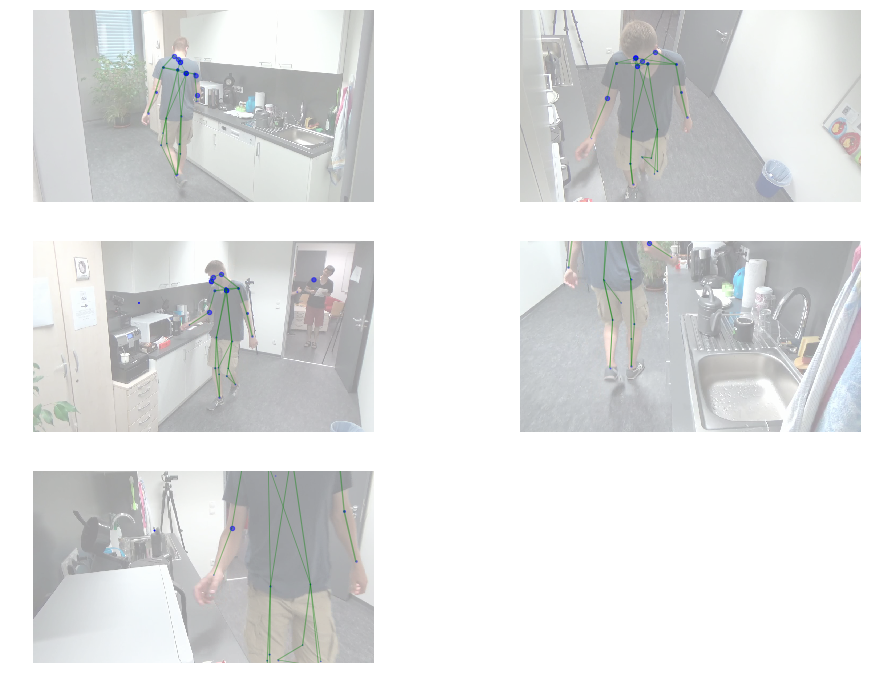

In [8]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ
from mvpose.algorithm.graphcut import PBOOST_SMALL, get_unary

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        if len(ptsA2d) == 0 or len(ptsB2d) == 0:
            continue
        
        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        unaryB = PBOOST_SMALL(np.clip(unaryB, a_min=0.00000001, a_max=0.99999999))
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 1)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 1)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*5, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*5, alpha=0.4)

plt.show()

In [9]:
# import mvpose.geometry.stereo as stereo

# jid = 17
# cam1 = 2
# cam2 = 1

# # ------------------------
# def draw_peaks(ax, cid, colors):
#     peaks2d = Debug.candidates2d.peaks2d[cid][jid]
#     for i, (x, y, s) in enumerate(peaks2d):
#         ax.scatter(x, y, color=colors[i], s=s*20)

# # ------------------------

# pts2d_1 = Debug.candidates2d.peaks2d_undistorted[cam1][jid][:, 0:2]
# pts2d_2 = Debug.candidates2d.peaks2d_undistorted[cam2][jid][:, 0:2]


    

# get_y = lambda a, b, c, x: (-c - a * x)/b

# NOSE_1_COLORS = ['black', 'red']
# NOSE_2_COLORS = ['blue', 'green']

# im1 = Im[cam1]
# im2 = Im[cam2]

# P1 = Calib[cam1].P
# P2 = Calib[cam2].P
# F = stereo.get_fundamental_matrix(P1, P2)

# epilines_1to2 = np.squeeze(
#     cv2.computeCorrespondEpilines(pts2d_1, 1, F))
# if len(epilines_1to2.shape) <= 1:
#     epilines_1to2 = np.expand_dims(epilines_1to2, axis=0)
    
# epilines_2to1 = np.squeeze(
#     cv2.computeCorrespondEpilines(pts2d_2, 2, F))
# if len(epilines_2to1.shape) <= 1:
#     epilines_2to1 = np.expand_dims(epilines_2to1, axis=0)

# fig = plt.figure(figsize=(16,12))

# ax = fig.add_subplot(1, 2, 1)
# ax.imshow(im1, alpha=0.5)
# ax.axis('off')
# draw_peaks(ax, cam1, NOSE_1_COLORS)

# for i, (a, b, c) in enumerate(epilines_2to1):
#     x1 = 0
#     y1 = get_y(a, b, c, x1)
#     x2 = 640
#     y2 = get_y(a, b, c, x2)

    
#     ax.plot([x1, x2], [y1, y2], color=NOSE_2_COLORS[i])


# ax = fig.add_subplot(1, 2, 2)
# ax.imshow(im2, alpha=0.5)
# ax.axis('off')
# draw_peaks(ax, cam2, NOSE_2_COLORS)

# for i, (a, b, c) in enumerate(epilines_1to2):
#     x1 = 0
#     y1 = get_y(a, b, c, x1)
#     x2 = 640
#     y2 = get_y(a, b, c, x2)
#     ax.plot([x1, x2], [y1, y2], color=NOSE_1_COLORS[i])
    

# plt.show()


In [10]:
im.shape

(720, 1280, 3)

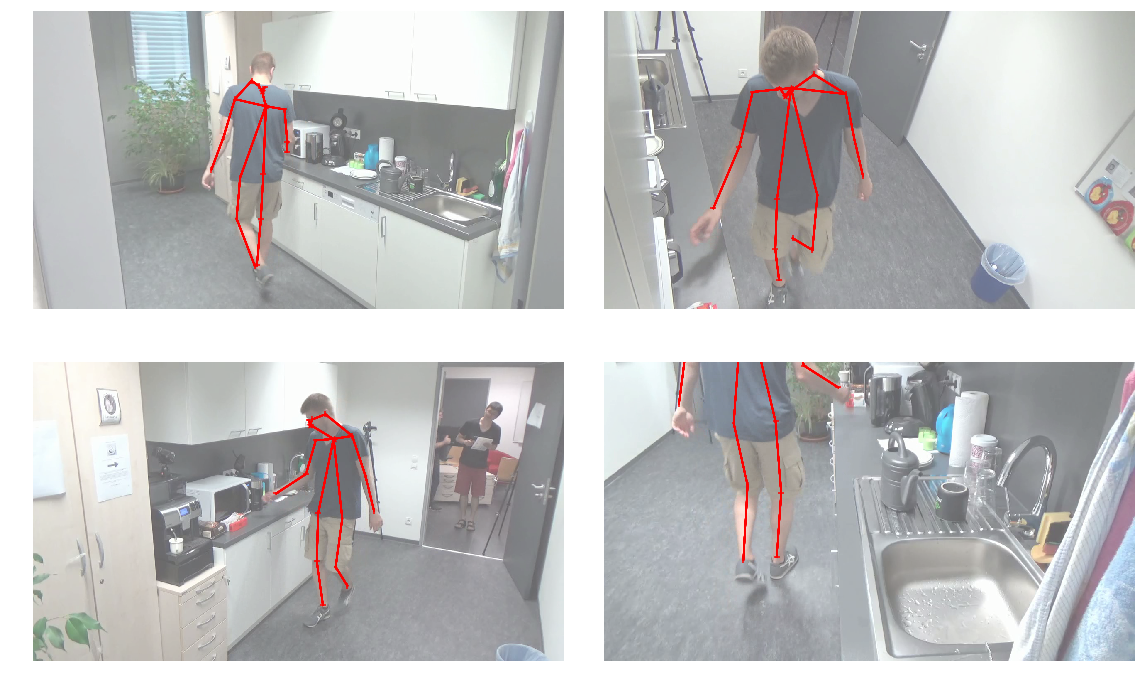

In [20]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections

fig = plt.figure(figsize=(16,10))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 1280])
    ax.set_ylim([720, 0])
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
    if idx == 3:
        break
        
plt.tight_layout()
plt.show()

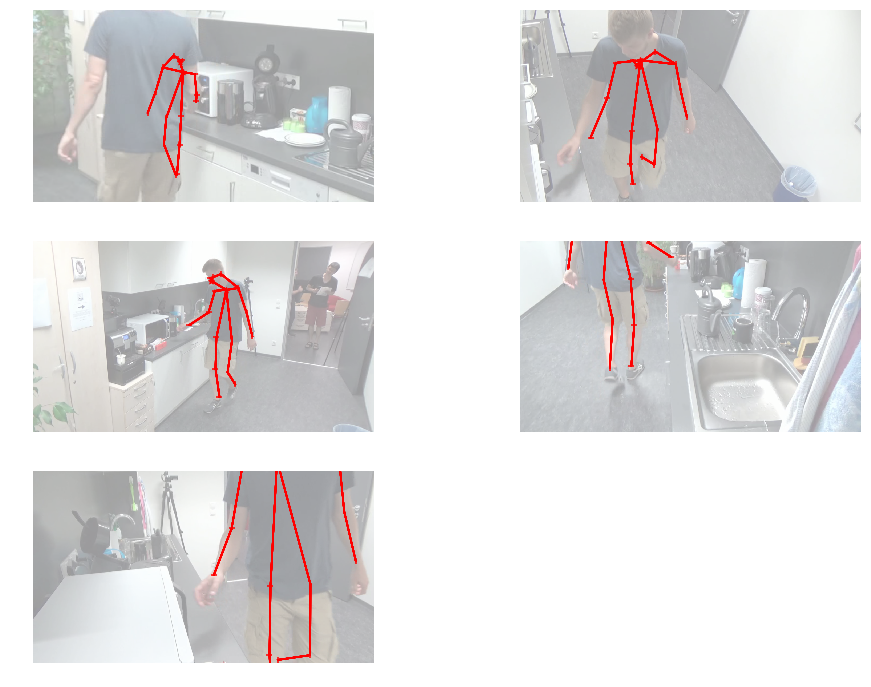

In [12]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = Debug.graphcut.person_candidates_all

fig = plt.figure(figsize=(16,12))

print()
colors = cs.rangecolor(len(Humans), (255, 0, 0), (0, 0, 255))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 1280])
    ax.set_ylim([720, 0])
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()